In [1]:
import sys
import os
myDir = os.getcwd()
parentDir = os.path.abspath(os.path.join(myDir, os.pardir))
sys.path.append(parentDir)

from pathlib import Path
path = Path(parentDir)
a=str(path.parent.absolute())

sys.path.append(a)

In [2]:
from MetaX.utils.taxaFuncAnalyzer import TaxaFuncAnalyzer
from MetaX.utils.taxaFuncPloter.basic_plot import BasicPlot


In [3]:
df_path = 'example_data/SW_TaxaFunc.tsv'
meta_path = 'example_data/SW_meta.tsv'
sw = TaxaFuncAnalyzer(df_path, meta_path)

In [4]:
sw.set_func('Description')
sw.set_multi_tables(level='s')

sw.set_group('Person')

batch_list is not set, Batch effect removal did not perform.
transform_method is not set, data transform did not perform.
normalize_method is not set, data normalization did not perform.
Original data shape: (3999, 229)
Starting to set Function table...
Function number: 830
Starting to set Taxa table...
Taxa number: 340
Taxa-Function number: 1272
group is set to Person
 {'V5', 'V2', 'V1', 'V4', 'V3'}


In [22]:
df = sw.get_intensity_matrix(func_name='ROK family')
df = sw.get_intensity_matrix(taxon_name="d__Bacteria|p__Actinobacteriota|c__Coriobacteriia|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella sp900762015")
display(df.head())

,V1_01,V1_02,V1_03,V1_04,V1_05,V1_06,V1_07,V1_08,V1_09,V1_10,...,V5_29,V5_30,V5_31,V5_32,V5_33,V5_34,V5_35,V5_36,V5_37,V5_38
Description,,,,,,,,,,,,,,,,,,,,,
Iron-containing alcohol dehydrogenase,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Methionine synthase vitamin-B12 independent,0,374688,260522,0,0,0,0,328480,0,400140,...,0,0,0,0,0,0,0,0,0,0
PTS HPr component phosphorylation site,0,0,0,172258,157402,0,0,0,173912,0,...,0,0,0,0,0,0,0,0,928917,662469


In [35]:
data = []
for i, name in enumerate(df.index):
    for j, sample in enumerate(df.columns):
        # 使用样本的索引作为虚拟的时间序列
        data.append([j, df.loc[name, sample], name])
print(data)

[[0, 0, 'Iron-containing alcohol dehydrogenase'], [1, 0, 'Iron-containing alcohol dehydrogenase'], [2, 0, 'Iron-containing alcohol dehydrogenase'], [3, 0, 'Iron-containing alcohol dehydrogenase'], [4, 0, 'Iron-containing alcohol dehydrogenase'], [5, 0, 'Iron-containing alcohol dehydrogenase'], [6, 0, 'Iron-containing alcohol dehydrogenase'], [7, 0, 'Iron-containing alcohol dehydrogenase'], [8, 0, 'Iron-containing alcohol dehydrogenase'], [9, 0, 'Iron-containing alcohol dehydrogenase'], [10, 0, 'Iron-containing alcohol dehydrogenase'], [11, 0, 'Iron-containing alcohol dehydrogenase'], [12, 0, 'Iron-containing alcohol dehydrogenase'], [13, 0, 'Iron-containing alcohol dehydrogenase'], [14, 0, 'Iron-containing alcohol dehydrogenase'], [15, 0, 'Iron-containing alcohol dehydrogenase'], [16, 0, 'Iron-containing alcohol dehydrogenase'], [17, 0, 'Iron-containing alcohol dehydrogenase'], [18, 0, 'Iron-containing alcohol dehydrogenase'], [19, 0, 'Iron-containing alcohol dehydrogenase'], [20, 0, '

In [70]:
from pyecharts import options as opts
from pyecharts.charts import Bar

# 假设你的DataFrame是df
x_data = list(df.columns)

c = (
    Bar()
    .add_xaxis(x_data)
)

for name in df.index:
    c.add_yaxis(name, list(df.loc[name, :]), stack="stack1", category_gap="50%")

c.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
c.set_global_opts(datazoom_opts=[opts.DataZoomOpts( type_="inside", range_start=0, range_end=100,), opts.DataZoomOpts(type_="slider", range_start=0, range_end=100,),],
                  legend_opts=opts.LegendOpts(pos_left="right", orient="vertical"),
                toolbox_opts=opts.ToolboxOpts( is_show=True, orient="vertical", pos_left="right", pos_top="center",),
                title_opts=opts.TitleOpts(title="Bar-显示 ToolBox"),
)



c.render_notebook()



In [81]:
from pyecharts import options as opts
from pyecharts.charts import Bar

import pandas as pd

class LinePlot:
    def __init__(self, tfobj):
        self.tfobj =  tfobj
    # plot intensity line for each sample
    # Example: plot_intensity_line(sw, func_name=func_name, taxon_name=taxon_name, fig_size=(30,20))

    def plot_intensity_line(self, taxon_name:str=None, groups:list = None, func_name:str=None, peptide_seq=None):

        df = self.tfobj.get_intensity_matrix(taxon_name=taxon_name, func_name=func_name, peptide_seq=peptide_seq, groups= groups)
        # create color list for groups & rename columns
        col_names = df.columns.tolist()
        meta_df = self.tfobj.meta_df
        meta_name = self.tfobj.meta_name
        groups_list = []
        new_col_names = []
        for i in col_names:
            group = meta_df[meta_df['Sample'] == i]
            group = group[meta_name].values[0]
            new_col_names.append(f'{i} ({group})')
            groups_list.append(group)
        df.columns = new_col_names
        index_name = df.index.name
        
        # create title
        if taxon_name is None:
            title = f'{func_name}'
        elif func_name is None:
            title = f'{taxon_name}'
        elif peptide_seq is not None:
            title = f'The intensity of {peptide_seq}'
        else:
            title = f'{taxon_name}\n{func_name}'
        
            
        return df
df = LinePlot(sw).plot_intensity_line(func_name="ROK family")

In [82]:
display(df.head())

,V1_01 (V1),V1_02 (V1),V1_03 (V1),V1_04 (V1),V1_05 (V1),V1_06 (V1),V1_07 (V1),V1_08 (V1),V1_09 (V1),V1_10 (V1),...,V5_29 (V5),V5_30 (V5),V5_31 (V5),V5_32 (V5),V5_33 (V5),V5_34 (V5),V5_35 (V5),V5_36 (V5),V5_37 (V5),V5_38 (V5)
Taxon,,,,,,,,,,,,,,,,,,,,,
d__Bacteria|p__Actinobacteriota|c__Actinomycetia|o__Actinomycetales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium pseudocatenulatum,395691,504180,780224,0,680716,0,0,504892,286673,270460,...,0,0,0,0,0,0,0,0,0,0
d__Bacteria|p__Bacteroidota|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Prevotella|s__Prevotella copri_A,0,107983,360580,0,0,0,0,0,0,261555,...,0,0,0,0,0,0,0,0,0,0
d__Bacteria|p__Firmicutes_A|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Agathobacter|s__Agathobacter rectalis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,546449,0,0
d__Bacteria|p__Firmicutes_A|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Roseburia|s__Roseburia hominis,246602,575718,595770,763091,818482,216592,890081,577186,413871,702795,...,676712,1622676,2097777,549815,2620374,2961584,3153684,4050247,2940956,2875664


In [98]:
from pyecharts import options as opts
from pyecharts.charts import Bar

import pandas as pd

class LinePlot:
    def __init__(self, tfobj):
        self.tfobj =  tfobj
    # plot intensity line for each sample
    # Example: plot_intensity_line(sw, func_name=func_name, taxon_name=taxon_name, fig_size=(30,20))

    def plot_intensity_line(self, taxon_name:str=None, groups:list = None, func_name:str=None, peptide_seq=None, fig_size:tuple = (20,12)):

        df = self.tfobj.get_intensity_matrix(taxon_name=taxon_name, func_name=func_name, peptide_seq=peptide_seq, groups= groups)
        # create color list for groups & rename columns
        col_names = df.columns.tolist()
        meta_df = self.tfobj.meta_df
        meta_name = self.tfobj.meta_name
        groups_list = []
        new_col_names = []
        for i in col_names:
            group = meta_df[meta_df['Sample'] == i]
            group = group[meta_name].values[0]
            new_col_names.append(f'{i} ({group})')
            groups_list.append(group)
        df.columns = new_col_names
        index_name = df.index.name
        
        # create title
        if taxon_name is None:
            title = f'{func_name}'
        elif func_name is None:
            title = f'{taxon_name}'
        elif peptide_seq is not None:
            title = f'The intensity of {peptide_seq}'
        else:
            title = f'{taxon_name}\n{func_name}'
        
        width = fig_size[0]
        height = fig_size[1]
            
        c = (
            Bar(init_opts=opts.InitOpts(width=f"{width}px", height=f"{height}px"))
            .add_xaxis(list(df.columns))
        )

        for name in df.index:
            c.add_yaxis(name, list(df.loc[name, :]), stack="stack1", category_gap="50%")

        c.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
        c.set_global_opts(datazoom_opts=[opts.DataZoomOpts( type_="inside", range_start=0, range_end=100,), opts.DataZoomOpts(type_="slider", range_start=0, range_end=100,),],
                        legend_opts=opts.LegendOpts(pos_left="right", orient="vertical", pos_top="5%",),
                        toolbox_opts=opts.ToolboxOpts( is_show=True, orient="vertical", pos_left="right", pos_top="bottom",),
                        title_opts=opts.TitleOpts(title=f"{title}", pos_left="center" ),
        )
        return c

# LinePlot(sw).plot_intensity_line(func_name="ROK family").render_notebook()
# LinePlot(sw).plot_intensity_line(func_name="ROK family").render_notebook()
LinePlot(sw).plot_intensity_line(func_name="ROK family", taxon_name="d__Bacteria|p__Actinobacteriota|c__Actinomycetia|o__Actinomycetales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium pseudocatenulatum").render_notebook()
LinePlot(sw).plot_intensity_line(taxon_name="d__Bacteria|p__Actinobacteriota|c__Actinomycetia|o__Actinomycetales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium pseudocatenulatum", fig_size=(1200, 900)).render_notebook()


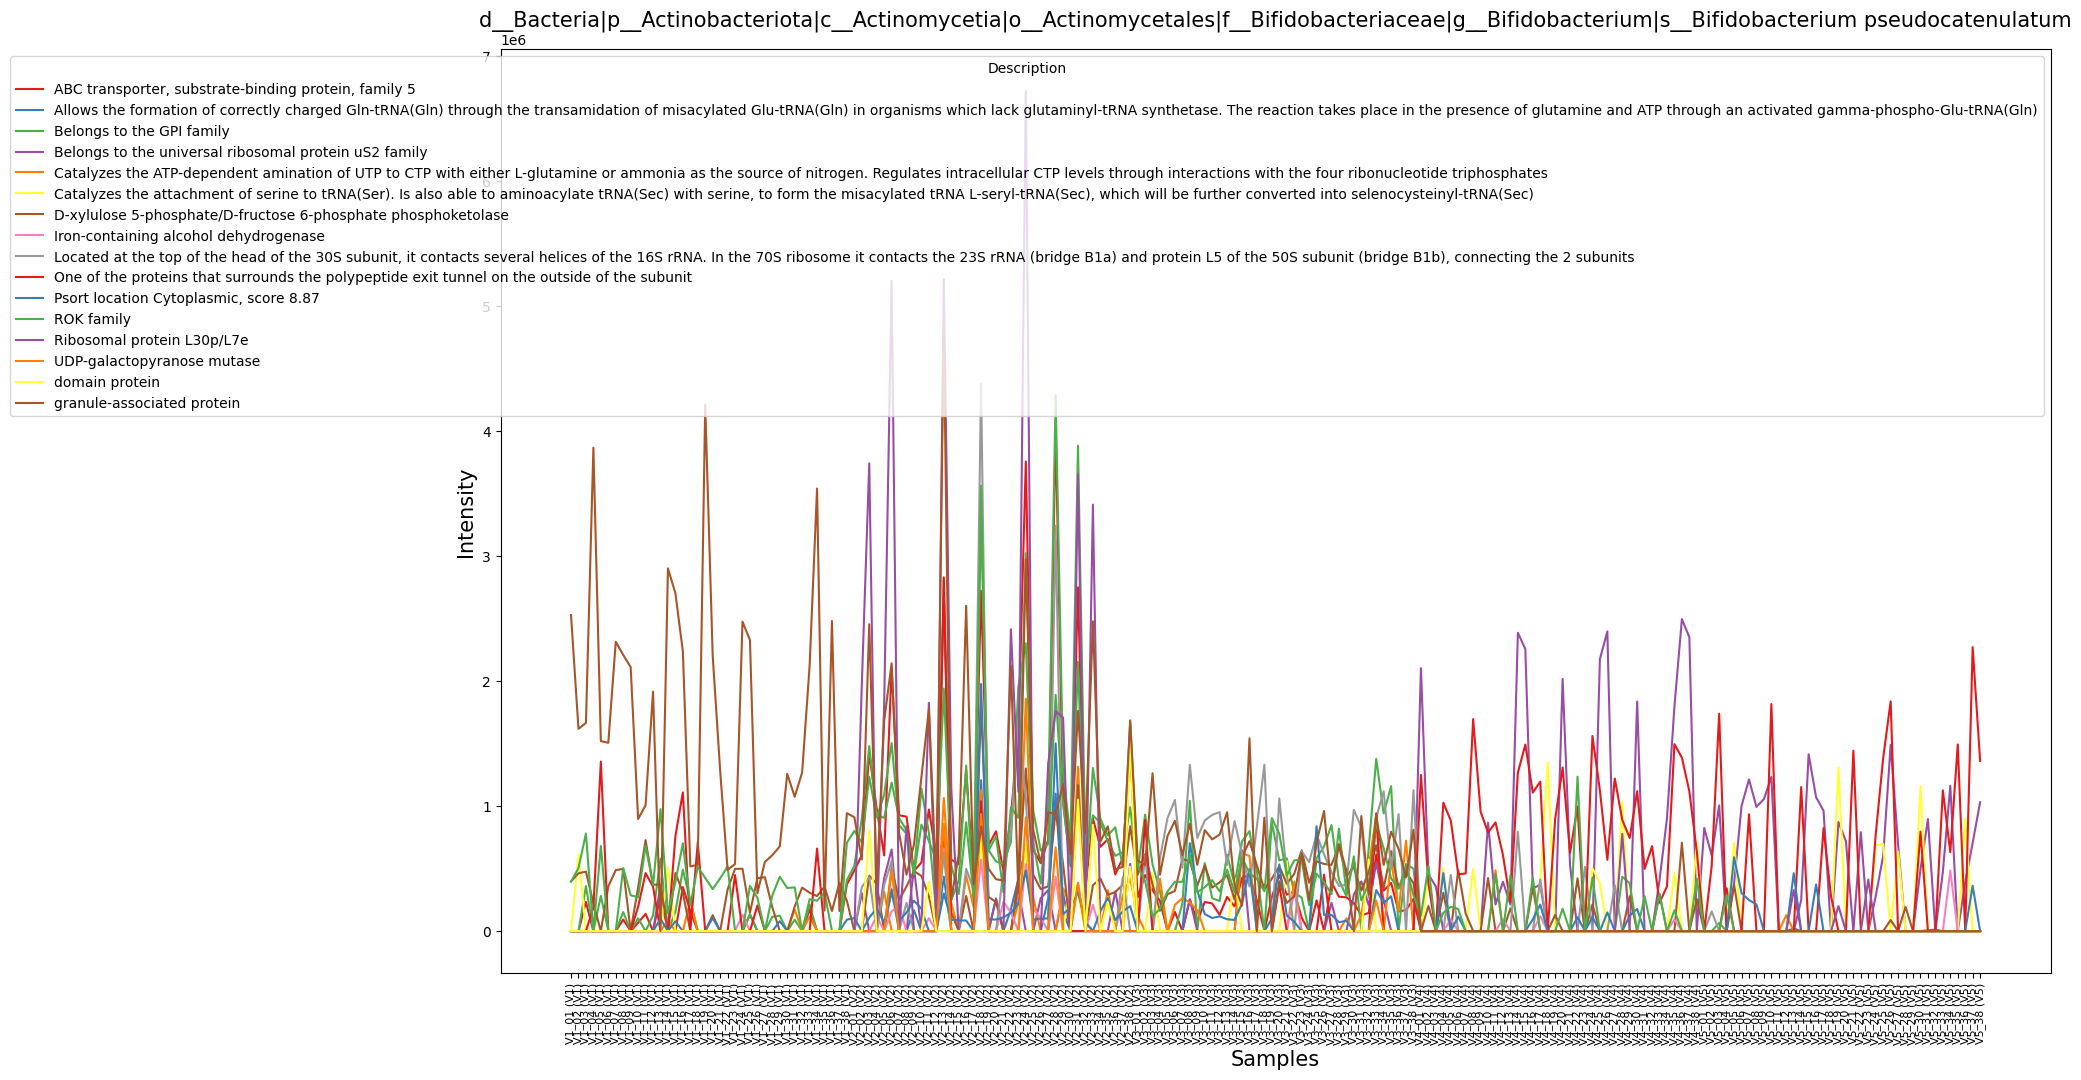

<Axes: title={'center': 'd__Bacteria|p__Actinobacteriota|c__Actinomycetia|o__Actinomycetales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium pseudocatenulatum'}, xlabel='Samples', ylabel='Intensity'>

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

class LinePlot:
    def __init__(self, tfobj):
        self.tfobj =  tfobj
    # plot intensity line for each sample
    # Example: plot_intensity_line(sw, func_name=func_name, taxon_name=taxon_name, fig_size=(30,20))

    def plot_intensity_line(self, taxon_name:str=None, groups:list = None, func_name:str=None, peptide_seq=None, width:int=20, height:int=12):
        fig_size = (width, height)

        df = self.tfobj.get_intensity_matrix(taxon_name=taxon_name, func_name=func_name, peptide_seq=peptide_seq, groups= groups)
        if df.empty:
            raise ValueError('No data to plot')
        # create color list for groups & rename columns
        col_names = df.columns.tolist()
        meta_df = self.tfobj.meta_df
        meta_name = self.tfobj.meta_name
        groups_list = []
        new_col_names = []
        for i in col_names:
            group = meta_df[meta_df['Sample'] == i]
            group = group[meta_name].values[0]
            new_col_names.append(f'{i} ({group})')
            groups_list.append(group)
        df.columns = new_col_names
        index_name = df.index.name
        
        # create title
        if taxon_name is None:
            title = f'{func_name}'
        elif func_name is None:
            title = f'{taxon_name}'
        elif peptide_seq is not None:
            title = f'The intensity of {peptide_seq}'
        else:
            title = f'{taxon_name}\n{func_name}'
            
            
        dfp = pd.melt(df.reset_index(), id_vars=index_name, var_name='Samples', value_name='Intensity')
        plt.figure(figsize=fig_size)
        fig = sns.lineplot(x='Samples', y='Intensity', hue=index_name, data=dfp, palette='Set1', legend = True)
        
        fig.set_title(title, fontsize=15)
        fig.set_xlabel('Samples', fontsize=15)
        fig.set_ylabel('Intensity', fontsize=15)
        fig.tick_params(axis='x', rotation=90, labelsize=8)
        
        plt.show()
        return fig

LinePlot(sw).plot_intensity_line(taxon_name="d__Bacteria|p__Actinobacteriota|c__Actinomycetia|o__Actinomycetales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium pseudocatenulatum")
